In [1]:
!pip install wbgapi

You should consider upgrading via the '/Users/mac/.pyenv/versions/3.10.3/bin/python3.10 -m pip install --upgrade pip' command.


In [2]:
import wbgapi as wb
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import matplotlib
from datetime import datetime
from dataclasses import dataclass
import pandas as pd
import random
from sklearn.metrics import mean_squared_error

In [3]:
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [4]:
QUERY_ID = ['EN.ATM.METH.EG.KT.CE']

features = ['EN.ATM.METH.EG.ZS','EN.ATM.METH.ZG', 
            'EN.ATM.METH.AG.ZS', 'EN.ATM.METH.AG.KT.CE',
           'NY.GDP.PCAP.CD', 'IS.AIR.DPRT', 'EG.USE.ELEC.KH.PC', 'AG.LND.TOTL.K2', 
            'EN.ATM.METH.AG.KT.CE', 'EN.ATM.METH.AG.ZS','EN.ATM.METH.EG.KT.CE', 'EN.ATM.METH.EG.ZS', 
            'EN.ATM.METH.KT.CE', 'EN.ATM.METH.ZG', 'EG.ELC.NGAS.ZS', 'EG.FEC.RNEW.ZS', 'EG.USE.COMM.FO.ZS',
            'EN.ATM.CO2E.KT', 'EG.USE.PCAP.KG.OE', 'EG.USE.CRNW.ZS'
           ]

BEGIN_YEAR_AVAILABLE = 1990
CURRENT_YEAR_AVAILABLE = 2019

#### GET OUR DATA FROM WORLD BANK API

We retrieve the data from the API using CountryAlpha2Code and the period time
- CountryAlpha2Code : Code that identify a country
- period time: a year or range of year

In [25]:
def HandlingPeriodFormatInput(year) :
    if year < BEGIN_YEAR_AVAILABLE :
        raise Exception ("The data available starting in 1990")
    if year > CURRENT_YEAR_AVAILABLE : #prediction
        period_time = range(BEGIN_YEAR_AVAILABLE, year)
        return period_time
    else :
        period_time = range(BEGIN_YEAR_AVAILABLE, CURRENT_YEAR_AVAILABLE)
        return period_time

In [26]:
def HandlingPeriodFormatInput(period_time) :
    
    if type(period_time) == int:      
        period_time = range(BEGIN_YEAR_AVAILABLE, period_time +1)
        return period_time
    
    if period_time[0] < BEGIN_YEAR_AVAILABLE :
        raise Exception ("The data available starting in 1990")
        
    if len(period_time) > 3 :
        raise Exception ("The format given is not correct try this format [initial date, final date, step")
        
    if len(period_time) == 2 :
        period_time.insert(2, 1)
        warnings.warn("the format should be [initial date, final date, step")

    if max(period_time) > CURRENT_YEAR_AVAILABLE + 1 or min(period_time) > CURRENT_YEAR_AVAILABLE:

        new_period_time = range(min(2021, period_time[0]), min(2022, period_time[1]), period_time[2])
    else :
         new_period_time = range(period_time[0], period_time[1], period_time[2])

    return new_period_time

In [31]:
@dataclass
class Country : 
    name : str
    CountryAlpha2Code : str
    period_time : list
    query_id : list

    def queryMethaneData(self) -> pd.DataFrame : #getDataMethEmissionByCountryAndYears
        period_time_range = HandlingPeriodFormatInput(self.period_time)
        df = wb.data.DataFrame(self.query_id, self.CountryAlpha2Code, time = period_time_range, columns='series')   
        return df.reset_index()
    
    def queryRelatedIndicators(self, predictors) -> pd.DataFrame :
        period_time_range = HandlingPeriodFormatInput(self.period_time)
        df = wb.data.DataFrame(predictors, self.CountryAlpha2Code, time = period_time_range, columns='series')   
        return df.reset_index()
           
    def plot(self):
        try :
            self.queryMethaneData().set_index('time').plot(figsize=(15, 6), title= self.name, colormap='Greens_r')
        except :
            self.queryMethaneData().plot(figsize=(15, 6), title= self.name, colormap='Greens_r')
        

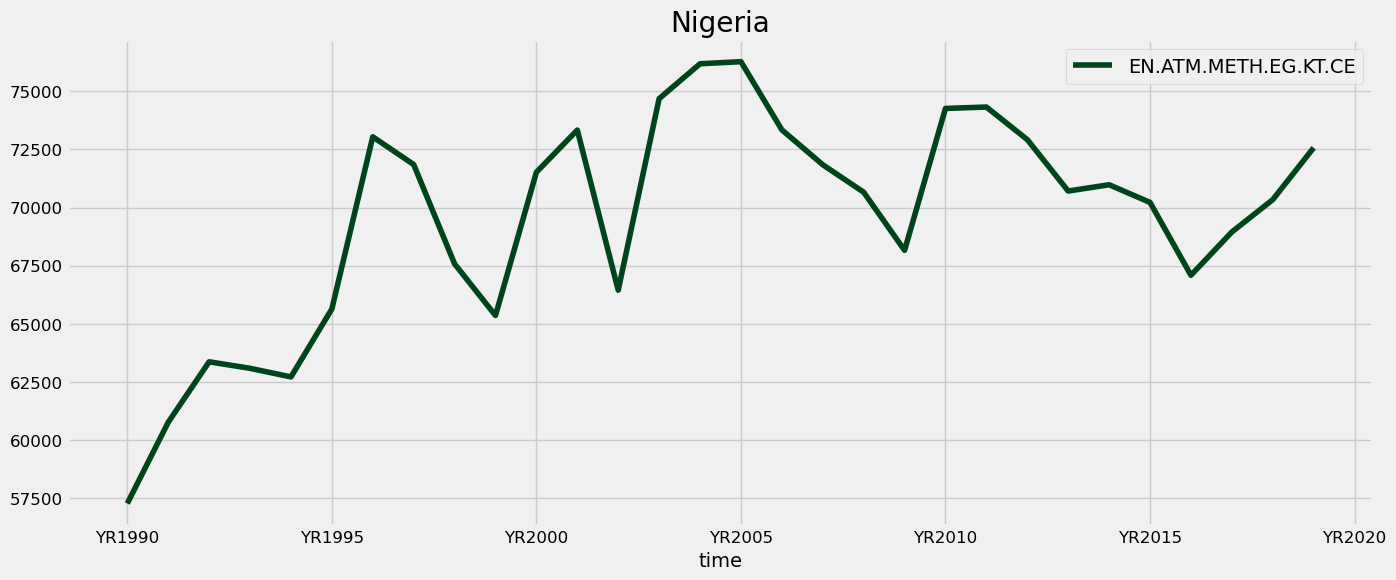

In [92]:
country = Country('Nigeria', 'NGA', [1990, 2026, 1], QUERY_ID)
data_country = country.queryMethaneData()
country.plot()

#### DATA PREPROCESSING

In [93]:
@dataclass
class Preprocessing :
    
    country : Country
    df: pd.DataFrame


    def CleaningAndRename(self):
        self.df['date'] = self.df['time'].str[2:]
        self.df['date'] = pd.to_datetime(self.df['date'])
        self.df = self.df.rename(columns = {'EN.ATM.METH.EG.KT.CE' : 'MethaneEmission'})
        del self.df['time']
        self.df = self.df.set_index('date')


    def HandlingFormatDateIndex(self) :
        BeginYear, LastYearToPredict,_ = self.country.period_time
        start = str(BeginYear) + "-01-01"
        end = str(LastYearToPredict) + "-01-01"
        dates = pd.date_range(start=start,end=end)
        self.df= self.df.reindex(dates, fill_value=0)
        self.df = self.df.resample('Y').sum().reset_index()
        self.df['index'] = self.df['index'].dt.year
        self.df= self.df.rename(columns={'index':'year'})
        self.df = self.df.set_index('year')
        self.df.replace(0.0, pd.np.nan, inplace=True)
        
    def MissingValue(self) :
        return sns.heatmap(self.df.isnull(),yticklabels=True,cbar=True,cmap='viridis')



<AxesSubplot: ylabel='year'>

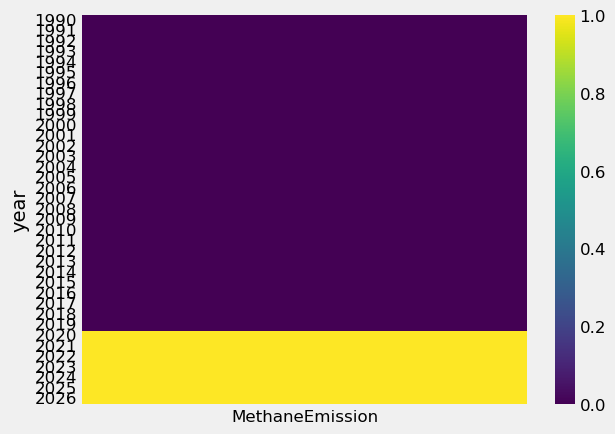

In [94]:
df_prepro = Preprocessing(country, data_country)
df_prepro.CleaningAndRename()
df_prepro.HandlingFormatDateIndex()
df_prepro.MissingValue()

In [95]:
df = df_prepro.df
df

,MethaneEmission
year,
1990,57280.0
1991,60770.0
1992,63370.0
1993,63090.0
1994,62720.0
1995,65640.0
1996,73040.0
1997,71850.0
1998,67580.0


### Handling Missing data

<AxesSubplot: >

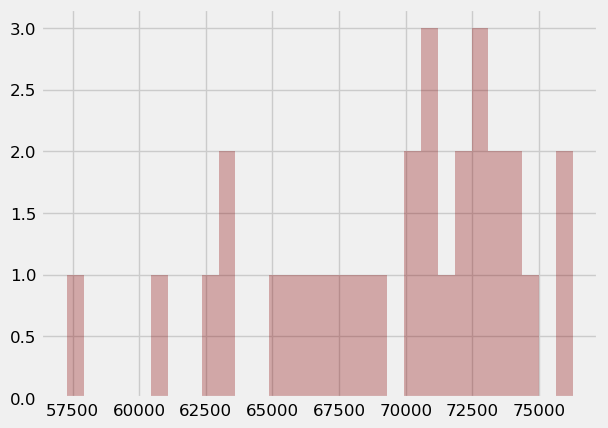

In [96]:
df['MethaneEmission'].hist(bins=30,color='darkred',alpha=0.3)

<AxesSubplot: xlabel='MethaneEmission'>

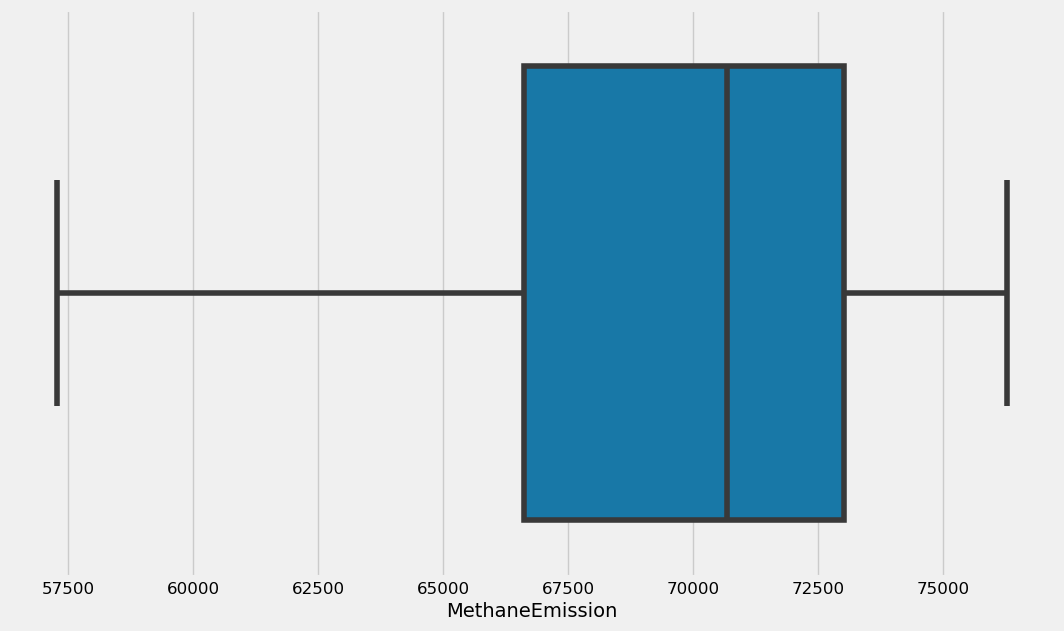

In [97]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='MethaneEmission',data=df,palette='winter')

#### METHOD I: Rolling Statistical

In [110]:
def rolling_statistical(df, window_size, kind):
    
    weights = np.linspace(1, window_size, window_size)*0.1
    df_imputed = df.copy()
    
    for column in df.columns:
        if kind == 'SMA':
            function = df_imputed[column] \
                                .rolling(window_size, min_periods=1) \
                                .mean().interpolate() 
            
            df_imputed[column].fillna(function, inplace=True)
            
        elif kind == 'WMA' :
            function = df_imputed[column].rolling(window_size).apply(
                lambda x: np.sum(weights*x)).interpolate()
            
            df_imputed[column].fillna(function, inplace=True)
            

        elif kind == 'EMA' :
            df_imputed[column] = df_imputed[column].fillna(df_imputed[column].ewm(span=window_size).mean())
            
#     df_imputed[column].plot(figsize=(15, 6), title= 'Rolling_statistical', colormap='jet')
#     plt.show()
            
    return df_imputed

In [111]:
df_imputed = rolling_statistical(df, 4, 'SMA')

In [112]:
from sklearn.impute import KNNImputer
def imputwithKNNImputer(df,k):
    imputer = KNNImputer(n_neighbors= k)
    imputed_data = imputer.fit_transform(df)
    df_imputed = pd.DataFrame(imputed_data, 
                           columns = df.columns)
    df_imputed.index = df.index
#     for column in df.columns :
#         df_imputed[column].plot(figsize=(15, 6), title= 'KNNImputer', colormap='jet')
#         plt.show()
      
    return df_imputed

In [113]:
df_imputed = imputwithKNNImputer(df, 3)

In [114]:
def Imputewithlinear_interpolation(df, order, kind='linear'):
    for column in df.columns :
        df[column ] = df[column].interpolate(method=kind, order=order)
#         df[column].plot(figsize=(15, 6), title= 'linear_interpolation', colormap='jet')
#         plt.show()
    return df

In [115]:
df_imputed = Imputewithlinear_interpolation(df, 1)

In [116]:
def compute_uncertainty(df, model, nbr_sim, kind_rolling= 'SMA', kind_interpo= 'linear', order = 1, windows_size = 4, k=3):
    df = df.dropna()
    for column in df.columns :
        all_estimations_error = []
        for _ in range(1, nbr_sim + 1) :
            df_random_null_value = replace_random_values(df, 0.5)
            if model == 'rolling_statistical' :
                df_predict = rolling_statistical(df_random_null_value, windows_size, kind_rolling)
            elif model == 'KNNImputer' :
                df_predict = imputwithKNNImputer(df_random_null_value , k)
                
        
            elif model == 'Linear_interpolation':
                    df_predict = Imputewithlinear_interpolation(df_random_null_value, order, kind_interpo)
                    
                
            mse = np.sqrt(mean_squared_error(df[column], df_predict[column]))
            all_estimations_error.append(mse)

        # compute the mean, standard deviation and confidence interval of the results
        mean = np.mean(all_estimations_error)
        std = np.std(all_estimations_error)
        confidence_interval = (mean - 1.96*std, mean + 1.96*std)
#         print('Mean: ', mean)
#         print('Standard deviation: ', std)
#         print('Confidence interval: ', confidence_interval)
        
        return std

In [117]:
def replace_random_values(df, fraction):
    for column in df.columns:
        df_train = df.copy()
        mask = np.random.rand(len(df_train)) < fraction
        if mask[0] == True:
            mask[0] = False
        df_train[column][mask] = np.nan
    return df_train

In [118]:
compute_uncertainty(df, 'rolling_statistical', 1000)

482.2163079859758

In [119]:
compute_uncertainty(df, 'KNNImputer', 1000)

407.0560983269556

In [120]:
compute_uncertainty(df, 'Linear_interpolation', 1000)

420.2598219428656

### Obtain and estimate when possible the Methane emissions for the last 10 years in all countries

In [39]:
df_methane_emission_ten_y = wb.data.DataFrame(['EN.ATM.METH.KT.CE'], mrv=10, columns = 'series').reset_index()

### ETL

In [58]:
DICO_GLOBAL_METHANE = {'EN.ATM.METH.ZG':'GlobalMethane(pct_change)', 
                       'EN.ATM.METH.KT.CE':'GlobalMethane(ktco2)'}

DICO_ENERGY = {'EN.ATM.METH.EG.ZS':'EnergieMethane', 
               'EN.ATM.METH.EG.KT.CE':'EnergieMethane(ktco2)', 
              }
DICO_ENERGY_RELATED = {'IS.AIR.DPRT':'AirTransport', 'EG.USE.ELEC.KH.PC': 'ConsoElec', 
                       'EG.ELC.NGAS.ZS':'EnergieNatualGaz(%total)',
              'EG.FEC.RNEW.ZS':'RenewableConso(%totalconso)', 
                       'EG.USE.COMM.FO.ZS':'FossilfuelConso(%totalconso)',
              'EN.ATM.CO2E.KT': 'CO2Emission(kt)', 
                'EG.USE.PCAP.KG.OE':'PrimaryEnergy(kgoil)', 
                       'EG.USE.CRNW.ZS':'PrimaryEnergy(%total)'}

DICO_AGRICULTURE_METHANE = {'EN.ATM.METH.AG.KT.CE':'AgricultureMethane(ktco2)', 
                    'EN.ATM.METH.AG.ZS':'AgricultureMethane(٪total)'
                   }

DICO_AGRICULTURE_RELATED = {'AG.LND.TOTL.K2':'LandArea(count)' }

In [59]:
features = ['EN.ATM.METH.EG.ZS','EN.ATM.METH.ZG', 
            'EN.ATM.METH.AG.ZS', 'EN.ATM.METH.AG.KT.CE', 'IS.AIR.DPRT', 
            'EG.USE.ELEC.KH.PC', 'AG.LND.TOTL.K2', 'EN.ATM.METH.AG.KT.CE',
            'EN.ATM.METH.AG.ZS','EN.ATM.METH.EG.KT.CE','EN.ATM.METH.EG.ZS', 
            'EN.ATM.METH.KT.CE', 'EN.ATM.METH.ZG', 'EG.ELC.NGAS.ZS', 'EG.FEC.RNEW.ZS', 
            'EG.USE.COMM.FO.ZS','EN.ATM.CO2E.KT', 'EG.USE.PCAP.KG.OE', 'EG.USE.CRNW.ZS'
           ]

In [ ]:
world_methane_emission = wb.data.DataFrame(features, columns = 'series').reset_index()

In [128]:
wme_df = pd.read_csv('world_methane_emission.csv', index_col = False)

In [129]:
wme_df = wme_df.rename(columns={'time':'year'})

In [130]:
wme_df

,Unnamed: 0,economy,year,LandArea(count),EnergieNatualGaz(%total),RenewableConso(%totalconso),FossilfuelConso(%totalconso),PrimaryEnergy(%total),ConsoElec,PrimaryEnergy(kgoil),CO2Emission(kt),AgricultureMethane(ktco2),AgricultureMethane(٪total),EnergieMethane(ktco2),EnergieMethane,GlobalMethane(ktco2),GlobalMethane(pct_change),AirTransport,meth_valuebylandaera
0,0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,ABW,1961,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,ABW,1962,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,ABW,1963,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,ABW,1964,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12519,12519,ZWE,2017,386850.0,NaN,82.46,NaN,NaN,NaN,NaN,10340.000153,6250.0,NaN,2970.0,NaN,12060.000420,NaN,3444.0,0.031175
12520,12520,ZWE,2018,386850.0,NaN,80.23,NaN,NaN,NaN,NaN,12380.000114,6420.0,NaN,3020.0,NaN,12340.000153,NaN,3444.0,0.031899
12521,12521,ZWE,2019,386850.0,NaN,81.50,NaN,NaN,NaN,NaN,11760.000229,6540.0,NaN,3070.0,NaN,12550.000191,NaN,NaN,0.032442
12522,12522,ZWE,2020,386850.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3450.0,NaN


### Notation

In [131]:
def compute_score(df, group, col = 'meth_valuebylandaera'):
    #compute max value methan emission by year
    dfgrouped = pd.DataFrame(df.groupby(group)[col].max()).reset_index()
    dfgrouped = dfgrouped.rename(columns={col: 'max_meth'})
    df = df.merge(dfgrouped, on=[group], how='left')
    
    #compute min value methan emission by year
    dfgrouped = pd.DataFrame(df.groupby(group)[col].min()).reset_index()
    dfgrouped = dfgrouped.rename(columns={col: 'min_meth'})
    df = df.merge(dfgrouped, on=[group], how='left')
    # scale the score between 0 to 4 by using min=max scaler method
    df[f'note_{group}']= np.where(df[col].notnull(), 
                              4*(df[col] - df['min_meth'])/
                              (df['max_meth'] - df['min_meth']), np.nan)
    del df['max_meth']
    del df['min_meth']
    return df

In [132]:
wme_df = compute_score(wme_df, 'year')

#### cleaning columns

In [133]:
del wme_df['Unnamed: 0']

In [134]:
columns_rename_list = [DICO_GLOBAL_METHANE, DICO_ENERGY, DICO_ENERGY_RELATED, 
                  DICO_AGRICULTURE_METHANE, DICO_AGRICULTURE_RELATED]

In [135]:
dico_final = {}
for dico in columns_rename_list:
    dico_final.update(dico)

In [136]:
wme_df.corr()

,year,LandArea(count),EnergieNatualGaz(%total),RenewableConso(%totalconso),FossilfuelConso(%totalconso),PrimaryEnergy(%total),ConsoElec,PrimaryEnergy(kgoil),CO2Emission(kt),AgricultureMethane(ktco2),AgricultureMethane(٪total),EnergieMethane(ktco2),EnergieMethane,GlobalMethane(ktco2),GlobalMethane(pct_change),AirTransport,meth_valuebylandaera,note_year
year,1.000000,-0.001494,0.225361,-0.041511,-0.078281,-0.088850,0.170940,0.068652,0.037499,0.011934,-0.075118,0.039646,0.036698,0.025416,0.130507,0.075771,0.034430,-0.051351
LandArea(count),-0.001494,1.000000,-0.023877,-0.054802,0.105977,-0.055177,0.127586,0.148067,0.598734,0.581925,0.002863,0.769319,0.179202,0.782438,-0.036939,0.480554,-0.062697,-0.067002
EnergieNatualGaz(%total),0.225361,-0.023877,1.000000,-0.374529,0.346475,-0.263584,0.153079,0.395811,-0.027967,-0.063808,-0.418832,0.073005,0.510186,0.006899,0.312124,-0.004743,0.284929,0.289344
RenewableConso(%totalconso),-0.041511,-0.054802,-0.374529,1.000000,-0.827692,0.923787,-0.273095,-0.411564,-0.142409,0.003484,0.431197,-0.160698,-0.044853,-0.092789,-0.027521,-0.130958,-0.166160,-0.173062
FossilfuelConso(%totalconso),-0.078281,0.105977,0.346475,-0.827692,1.000000,-0.888778,0.194843,0.366047,0.159551,0.045932,-0.357586,0.165217,0.312318,0.135278,-0.026944,0.108735,0.099502,0.103518
PrimaryEnergy(%total),-0.088850,-0.055177,-0.263584,0.923787,-0.888778,1.000000,-0.418362,-0.457091,-0.129914,0.045498,0.386604,-0.112704,-0.235158,-0.046390,-0.040229,-0.120328,-0.109976,-0.115436
ConsoElec,0.170940,0.127586,0.153079,-0.273095,0.194843,-0.418362,1.000000,0.810961,0.126274,-0.056641,-0.225988,0.051868,0.084477,0.006649,0.114412,0.231695,0.286121,0.289642
PrimaryEnergy(kgoil),0.068652,0.148067,0.395811,-0.411564,0.366047,-0.457091,0.810961,1.000000,0.138583,-0.053045,-0.360668,0.100643,0.338813,0.039398,0.172051,0.221569,0.314726,0.318916
CO2Emission(kt),0.037499,0.598734,-0.027967,-0.142409,0.159551,-0.129914,0.126274,0.138583,1.000000,0.612203,-0.067177,0.832964,0.143707,0.842451,-0.030234,0.765877,-0.024179,-0.026914
AgricultureMethane(ktco2),0.011934,0.581925,-0.063808,0.003484,0.045932,0.045498,-0.056641,-0.053045,0.612203,1.000000,0.150323,0.514715,0.002127,0.855711,-0.028069,0.406416,-0.043890,-0.046276


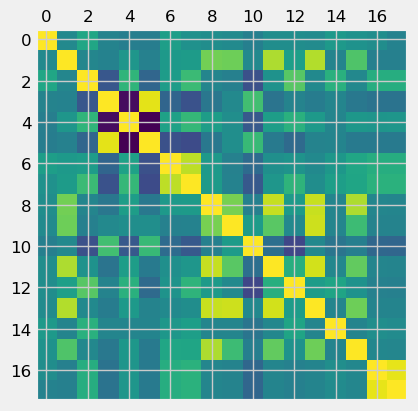

In [137]:
import matplotlib.pyplot as plt

plt.matshow(wme_df.corr())
plt.show()

In [138]:
##Feature selection based on correlation

In [139]:
predictors = ['GlobalMethane(ktco2)', 'LandArea(count)', 'CO2Emission(kt)', 'AgricultureMethane(ktco2)',
              'EnergieMethane(ktco2)', 'AirTransport', 'note_year', 'meth_valuebylandaera']
# predictors = ['GlobalMethane(ktco2)', 'CO2Emission(kt)', 'AgricultureMethane(ktco2)','EnergieMethane(ktco2)', 'AirTransport', 'note_year']
feature_selected = ['economy', 'year'] + predictors

In [140]:
wme_df_final = wme_df[feature_selected]

In [141]:
wme_df_final

,economy,year,GlobalMethane(ktco2),LandArea(count),CO2Emission(kt),AgricultureMethane(ktco2),EnergieMethane(ktco2),AirTransport,note_year,meth_valuebylandaera
0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,1961,NaN,180.0,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,1962,NaN,180.0,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,1963,NaN,180.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,1964,NaN,180.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
12519,ZWE,2017,12060.000420,386850.0,10340.000153,6250.0,2970.0,3444.0,0.005856,0.031175
12520,ZWE,2018,12340.000153,386850.0,12380.000114,6420.0,3020.0,3444.0,0.005889,0.031899
12521,ZWE,2019,12550.000191,386850.0,11760.000229,6540.0,3070.0,NaN,0.005836,0.032442
12522,ZWE,2020,NaN,386850.0,NaN,NaN,NaN,3450.0,NaN,NaN


### Note by cluster

In [142]:
from sklearn.cluster import KMeans

In [143]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_clusters(data, labels, centroids):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()

In [144]:
@dataclass
class kmeans_model :
    CountryAlpha2Code : str
    year : str
    df: pd.DataFrame
    
    def preprocessing(self):
        
        self.df = self.df[self.df['year'] == min(float(self.year), CURRENT_YEAR_AVAILABLE)]
        self.df = self.df.dropna(subset=self.df.columns)
#         self.df = self.df.reset_index()
        data = self.df[PREDICTORS].copy()
        #normalization between 0 to 4
        data = ((data - data.min()) / (data.max() - data.min())) * 3 + 1
        
        print(data.describe)
        
        return data
    
    def model_train(self, k):
        kmeans = KMeans(k)
        kmeans.fit(self.preprocessing())
        return kmeans
        
        
    def compute_labels_centroids(self, k):
        labels = self.model_train(k).labels_
        centroids = self.model_train(k).cluster_centers_
        return labels, centroids
    

In [149]:
PREDICTORS = ['GlobalMethane(ktco2)', 'LandArea(count)', 'CO2Emission(kt)',
              'AgricultureMethane(ktco2)','EnergieMethane(ktco2)', 
              'AirTransport', 'note_year'
            ]

In [146]:
model = kmeans_model('FRA', 2009, wme_df_final)

In [147]:
def cluster_score(CountryAlphaCode, year, df):
    if type(year) != int :
        raise Exception('the year should be numerical value')

    model = kmeans_model(CountryAlphaCode, year, df)
    data = model.preprocessing()
    labels, centroids = model.compute_labels_centroids(4)
    plot_clusters(data, labels, centroids.T)
    labels = pd.DataFrame(labels, columns = ['labels'])
    df = df.merge(labels, left_index=True, right_index=True)
    df = compute_score(df, 'labels', 'meth_valuebylandaera')
    avg_by_cluster = df.groupby(['labels'], as_index=False).agg(
                      {'GlobalMethane(ktco2)':['mean','std'], 'note_year':['first']})

    avg_by_cluster.columns = ['labels'] + ['_'.join(col) for col in avg_by_cluster.columns.values[1:]]
    avg_by_cluster = avg_by_cluster.rename(columns={'GlobalMethane(ktco2)_mean' : 'Methane_emission_estimated',
                               'GlobalMethane(ktco2)_std': 'uncertainty',
                               'note_year_first': 'score_cluster'})

    df = df.merge(avg_by_cluster, how='left', on='labels')

    return df

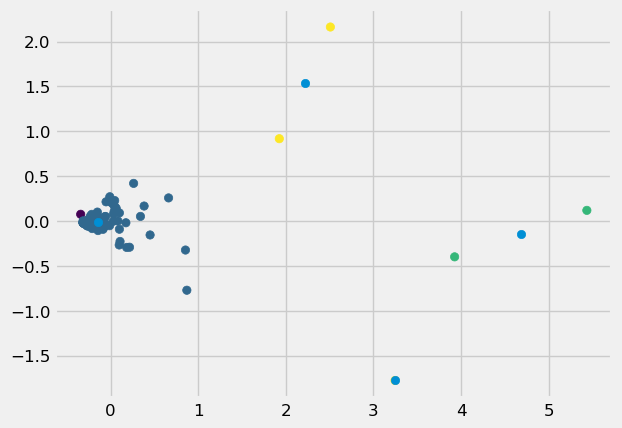

,economy,year,GlobalMethane(ktco2),LandArea(count),CO2Emission(kt),AgricultureMethane(ktco2),EnergieMethane(ktco2),AirTransport,note_year,meth_valuebylandaera,labels,note_labels,Methane_emission_estimated,uncertainty,score_cluster
0,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,11634.285688,3300.063345,0.005917
1,ABW,1961,NaN,180.0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,11634.285688,3300.063345,0.005917
2,ABW,1962,NaN,180.0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,11634.285688,3300.063345,0.005917
3,ABW,1963,NaN,180.0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,11634.285688,3300.063345,0.005917
4,ABW,1964,NaN,180.0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,11634.285688,3300.063345,0.005917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,AFG,2016,15829.999924,652230.0,5300.000191,10630.0,2190.0,22770.000,0.004657,0.024271,1,3.775701,11634.285688,3300.063345,0.005917
119,AFG,2017,15609.999657,652230.0,4780.000210,10330.0,2210.0,24207.000,0.004496,0.023933,1,3.684319,11634.285688,3300.063345,0.005917
120,AFG,2018,15909.999847,652230.0,6070.000172,10540.0,2220.0,10454.000,0.004503,0.024393,1,3.808930,11634.285688,3300.063345,0.005917
121,AFG,2019,16370.000839,652230.0,6079.999924,10920.0,2230.0,7334.000,0.004515,0.025099,1,4.000000,11634.285688,3300.063345,0.005917


In [148]:
cluster_score('FRA', 2009, wme_df_final)